In [26]:
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import statsmodels.api as sm

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, acf
from statsmodels.graphics.tsaplots import plot_pacf, pacf
import holidays
from pmdarima.arima import auto_arima
# from fbprophet import Prophet
# from fbprophet.plot import plot_plotly, add_changepoints_to_plot
# from keras.models import Sequential
# from keras.layers import Dense

# from keras.optimizers import Adam
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings('ignore')

# loading the data

In [2]:
### 4 regions
east=pd.read_csv('final data/east_daily.csv', index_col=0, parse_dates=[0])
print(east.shape)
east.tail()

(1136, 1)


,daily_deaths
date,
2023-03-19,0
2023-03-20,7
2023-03-21,14
2023-03-22,266
2023-03-23,80


In [3]:
midwest=pd.read_csv('final data/midwest_stationary.csv', index_col=0, parse_dates=[0])
print(midwest.shape)
midwest.tail()

(1136, 1)


,daily_deaths
date,
2023-03-19,0.0
2023-03-20,23.0
2023-03-21,108.0
2023-03-22,-91.0
2023-03-23,192.0


In [4]:
south=pd.read_csv('final data/south_daily.csv', index_col=0, parse_dates=[0])
print(south.shape)
south.tail()

(1136, 1)


,daily_deaths
date,
2023-03-19,0
2023-03-20,71
2023-03-21,31
2023-03-22,240
2023-03-23,58


In [5]:
west=pd.read_csv('final data/west_stationary.csv', index_col=0, parse_dates=[0])
print(east.shape)
west.tail()

(1136, 1)


,daily_deaths
date,
2023-03-19,0.0
2023-03-20,37.0
2023-03-21,-4.0
2023-03-22,151.0
2023-03-23,-95.0


# stationary analysis - ALL stationary

In [8]:
X = east.daily_deaths
result = adfuller(X)
print('East ADF Statistic: %f' % result[0])
print('East p-value: %f' % result[1])
print('East Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

X = midwest.daily_deaths
result = adfuller(X)
print('Midwest ADF Statistic: %f' % result[0])
print('Midwest p-value: %f' % result[1])
print('Midwest Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

X = south.daily_deaths
result = adfuller(X)
print('South ADF Statistic: %f' % result[0])
print('South p-value: %f' % result[1])
print('South Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

X = west.daily_deaths
result = adfuller(X)
print('West ADF Statistic: %f' % result[0])
print('West p-value: %f' % result[1])
print('West Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

East ADF Statistic: -3.842138
East p-value: 0.002504
East Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
Midwest ADF Statistic: -6.612100
Midwest p-value: 0.000000
Midwest Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
South ADF Statistic: -3.104854
South p-value: 0.026196
South Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568
West ADF Statistic: -5.691688
West p-value: 0.000001
West Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


# Visualizing the Data

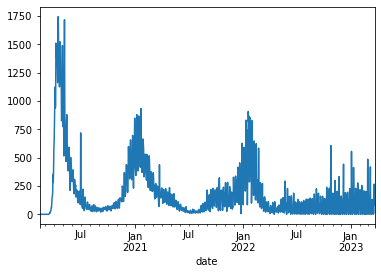

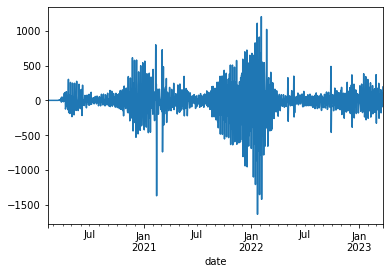

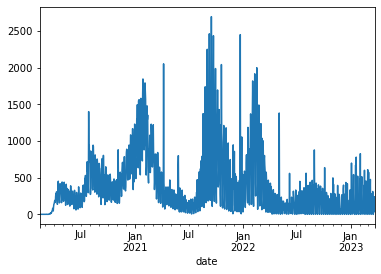

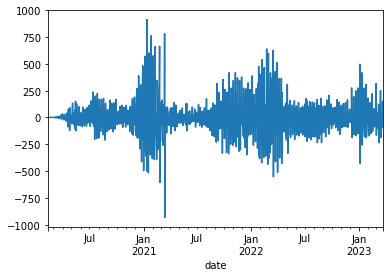

In [9]:
east['daily_deaths'].plot()
plt.show()

midwest['daily_deaths'].plot()
plt.show()

south['daily_deaths'].plot()
plt.show()

west['daily_deaths'].plot()
plt.show()

# splitting into train test
- setting a specific number for train test i.e. train is any data before 2023 and test is the last couple of months

In [11]:
easttrain = east[east.index < '2023-01-01']
easttest = east[east.index >= '2023-01-01']
print(easttrain.shape, easttest.shape)

midwesttrain = midwest[midwest.index < '2023-01-01']
midwesttest = midwest[midwest.index >= '2023-01-01']
print(midwesttrain.shape, midwesttest.shape)

southtrain = south[south.index < '2023-01-01']
southtest = south[south.index >= '2023-01-01']
print(southtrain.shape, southtest.shape)

westtrain = west[west.index < '2023-01-01']
westtest = west[west.index >= '2023-01-01']
print(westtrain.shape, westtest.shape)

(1054, 1) (82, 1)
(1054, 1) (82, 1)
(1054, 1) (82, 1)
(1054, 1) (82, 1)


# Visualizing data again

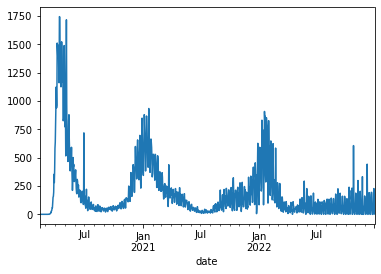

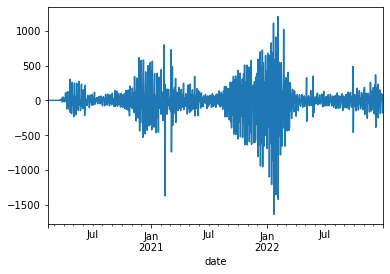

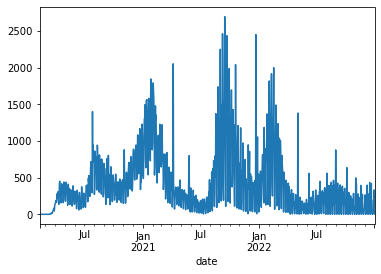

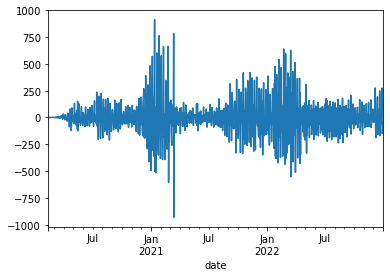

In [12]:
easttrain['daily_deaths'].plot()
plt.show()

midwesttrain['daily_deaths'].plot()
plt.show()

southtrain['daily_deaths'].plot()
plt.show()

westtrain['daily_deaths'].plot()
plt.show()

## plotting ACF and PACF
- For AR models & its order (p): the ACF will dampen exponentially.
    - The PACF will identify the order of the AR model:
    - The AR(1) model would have one significant spike at lag 1 on the PACF.
    - The AR(3) model would have significant spikes on the PACF at lags 1, 2, & 3.
    
- For MA models & its order (q): The PACF will dampen exponentially.
    - The ACF will be used to identify the order of the MA process.
    - The MA(1) has one significant spike in the ACF at lag 1.
    - The MA(3) has three significant spikes in the ACF at lags 1, 2, & 3
    
Based on the plots below:
- AR model (p): we need
    - the ACF does in fact dampen exponentially
    - the PACF demonstrates this would be AR(3)
- MA model: we may not need
    - the PACF doesn't exactly dampen exponentially
    - the ACF has one significant spike at lag 1 so MA(1)


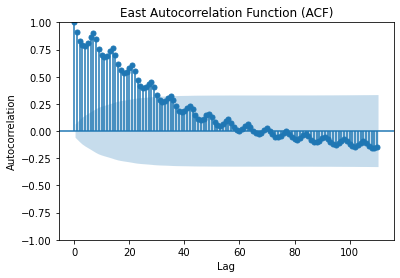

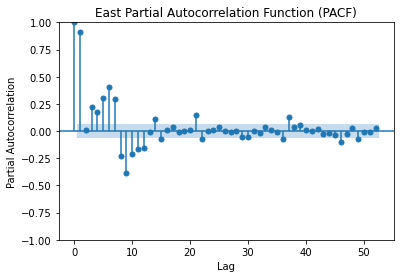

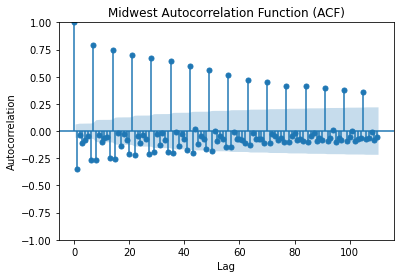

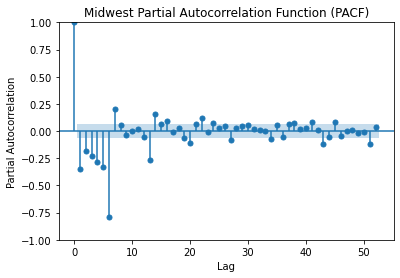

In [54]:
plot_acf(easttrain['daily_deaths'].iloc[20:], lags = 110) 
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('East Autocorrelation Function (ACF)')
plt.show()

plot_pacf(easttrain['daily_deaths'].iloc[20:],lags=52)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('East Partial Autocorrelation Function (PACF)')
plt.show()

plot_acf(midwesttrain['daily_deaths'].iloc[20:], lags = 110) 
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Midwest Autocorrelation Function (ACF)')
plt.show()

plot_pacf(midwesttrain['daily_deaths'].iloc[20:],lags=52)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Midwest Partial Autocorrelation Function (PACF)')
plt.show()

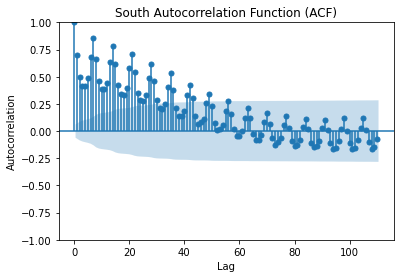

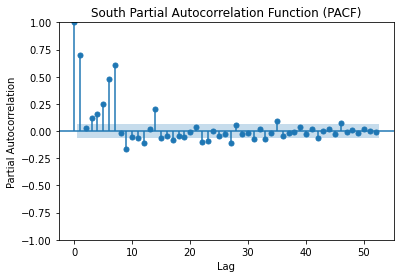

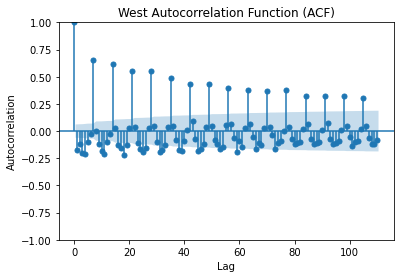

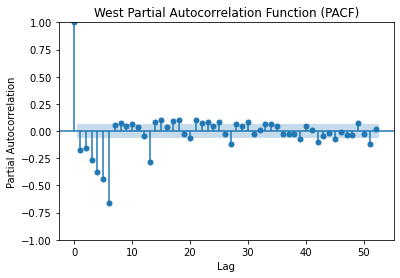

In [55]:
plot_acf(southtrain['daily_deaths'].iloc[20:], lags = 110) 
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('South Autocorrelation Function (ACF)')
plt.show()

plot_pacf(southtrain['daily_deaths'].iloc[20:],lags=52)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('South Partial Autocorrelation Function (PACF)')
plt.show()

plot_acf(westtrain['daily_deaths'].iloc[20:], lags = 110) 
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('West Autocorrelation Function (ACF)')
plt.show()

plot_pacf(westtrain['daily_deaths'].iloc[20:],lags=52)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('West Partial Autocorrelation Function (PACF)')
plt.show()

# Building the ARIMA
- so according to ACF and PACF plots we will need p = 3 and q = 1 or 0

### grid search p and q
- according to grid search p = 4 and q = 4 result in the lowest aic for east and midwest
- p = 3 and q = 4 for south
- p = 4 and q = 3 for west

- building out the models and testing (1) p = 4, q= 4 , (2) p = 3, q = 4, and (3) p = 4, q = 3 i found that the overall combined MAE is lower for (1)
    - combined MAE = 278 for (1), 281 for (2), and 294 for (3)

In [61]:
results=[]
for p in range(0,5):
    for q in range(0,5):
        model=ARIMA(easttrain['daily_deaths'],order=(p,0,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
24,4,4,12386.428461
18,3,3,12393.592764
19,3,4,12396.975226
22,4,2,12438.885701
23,4,3,12452.957164
14,2,4,12585.899771
13,2,3,12640.010182
9,1,4,12688.766342
21,4,1,12706.274494
16,3,1,12733.411967


In [62]:
results=[]
for p in range(0,5):
    for q in range(0,5):
        model=ARIMA(midwesttrain['daily_deaths'],order=(p,0,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
24,4,4,13722.872495
23,4,3,13727.569858
19,3,4,13791.556243
17,3,2,13819.446278
14,2,4,13844.418468
9,1,4,13845.661212
22,4,2,13848.496327
4,0,4,13852.668984
21,4,1,13881.782265
18,3,3,13917.585705


In [63]:
results=[]
for p in range(0,5):
    for q in range(0,5):
        model=ARIMA(southtrain['daily_deaths'],order=(p,0,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
19,3,4,14421.481395
24,4,4,14442.155525
17,3,2,14613.705758
14,2,4,14704.296806
9,1,4,14718.104594
21,4,1,14750.925600
16,3,1,14814.332503
18,3,3,14817.236067
7,1,2,14849.098718
12,2,2,14851.013103


In [64]:
results=[]
for p in range(0,5):
    for q in range(0,5):
        model=ARIMA(westtrain['daily_deaths'],order=(p,0,q)).fit()
        results.append([p,q,model.aic])
pd.DataFrame(results, columns=['p','q','aic']).sort_values('aic')

,p,q,aic
23,4,3,12735.776062
18,3,3,12747.358953
19,3,4,12758.142620
13,2,3,12773.486733
14,2,4,12796.443375
24,4,4,12804.140648
17,3,2,12942.830341
21,4,1,13009.444292
12,2,2,13053.087027
22,4,2,13070.096258


## defining a function of MASE

In [118]:
def MASE(Actual, Predicted):
    n = len(Actual)
    
    mae = mean_absolute_error(Actual, Predicted)

    # Calculate the denominator
    denominator = 1 / (n - 1) * np.sum(np.abs(Predicted.iloc[1:].values - Actual.iloc[:-1].values))

    # Avoid division by zero or small denominators
    if denominator > 1e-6:
        mase = mae / denominator
    else:
        mase = np.inf

    return mase

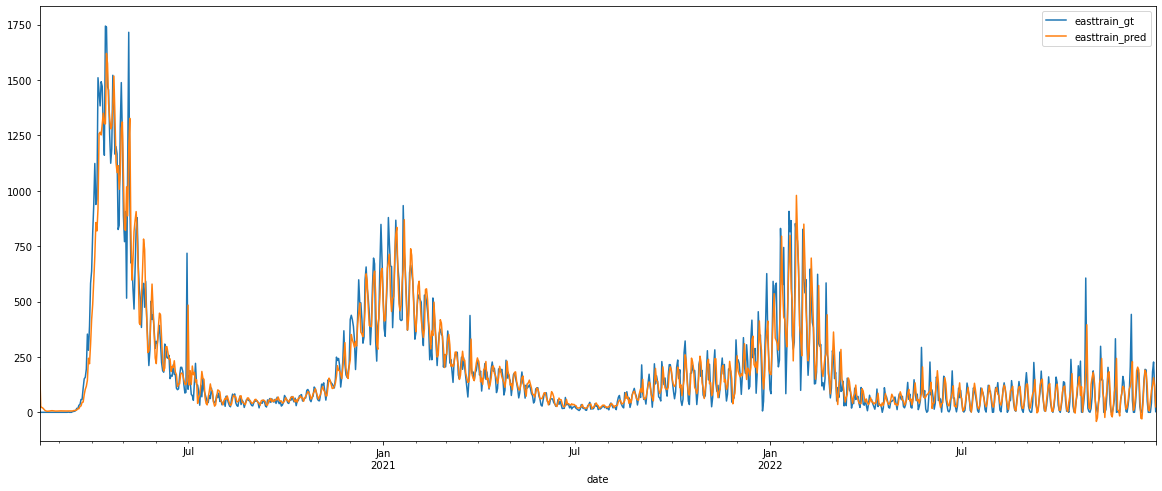

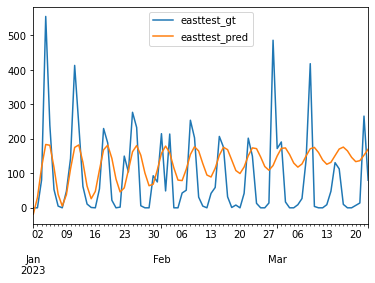

Training Set Metrics:
MAE: 48.959629673958354
MASE: 0.00020428320146929872

Testing Set Metrics:
MAE: 90.99969083393749
MASE: 0.010062030136522139


In [125]:
emodel = ARIMA(easttrain['daily_deaths'], order=(4, 0, 4))
emodel=emodel.fit()

easttrain_pred=emodel.fittedvalues
pd.concat([easttrain, easttrain_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['easttrain_gt', 'easttrain_pred'])
plt.show()

easttest_pred=emodel.predict(start=len(easttrain), end=len(easttrain)+len(easttest)-1, dynamic=True)
pd.concat([easttest, easttest_pred], axis=1).plot()
plt.legend(['easttest_gt', 'easttest_pred'])
plt.show()

# Calculate MAE for the training set
mae_train = mean_absolute_error(easttrain, easttrain_pred)
mase_train = MASE(easttrain, easttrain_pred)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)


# Calculate MAE for the testing set
mae_test = mean_absolute_error(easttest, easttest_pred)
mase_test = MASE(easttest, easttest_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

In [126]:
emodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           daily_deaths   No. Observations:                 1054
Model:                 ARIMA(4, 0, 4)   Log Likelihood               -6183.214
Date:                Thu, 15 Feb 2024   AIC                          12386.428
Time:                        17:12:50   BIC                          12436.032
Sample:                    02-12-2020   HQIC                         12405.233
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        195.2981    116.426      1.677      0.093     -32.892     423.489
ar.L1          1.4852      0.093     15.974      0.000       1.303       1.667
ar.L2         -0.5160      0.206     -2.506      0.012      -0.920      -0.112
ar.L3         -0.6961      0.203     -3.435      0.001      -1.093      -0.299
ar.L4          0.7115      0.089      8.015      0.000       0.537       0.885
ma.L1         -0.9549      0.093    -10.315      0.000      -1.136      -0.773
ma.L2         -0.0189      0.148     -0.128      0.898      -0.308       0.271
ma.L3          0.7928      0.108      7.338      0.000       0.581       1.005
ma.L4         -0.3213      0.029    -10.950      0.000      -0.379      -0.264
sigma2      7251.3750    149.803     48.406      0.000    6957.766    7544.984
===================================================================================
Ljung-Box (L1) (Q):                   1.23   Jarque-Bera (JB):              5216.44
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                             1.30
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

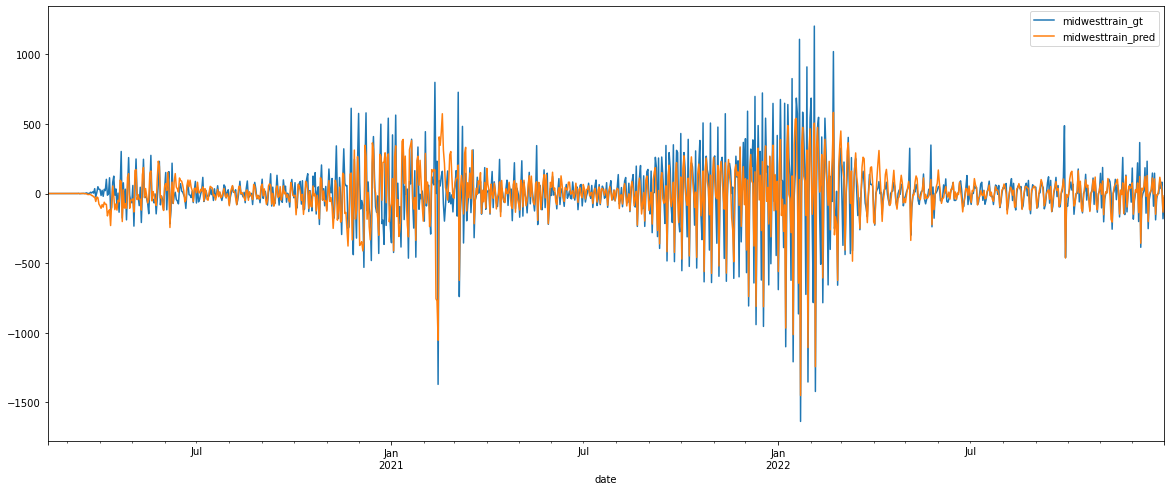

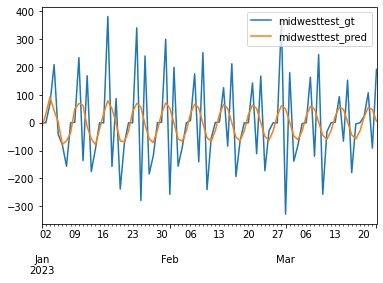

Training Set Metrics:
MAE: 91.75398775131288
MASE: 0.0004408295495924626

Testing Set Metrics:
MAE: 107.38298886520553
MASE: 0.01034536899207185


In [127]:
mmodel = ARIMA(midwesttrain['daily_deaths'], order=(4, 0, 4))
mmodel=mmodel.fit()

midwesttrain_pred=mmodel.fittedvalues
pd.concat([midwesttrain, midwesttrain_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['midwesttrain_gt', 'midwesttrain_pred'])
plt.show()

midwesttest_pred=mmodel.predict(start=len(midwesttrain), end=len(midwesttrain)+len(midwesttest)-1, dynamic=True)
pd.concat([midwesttest, midwesttest_pred], axis=1).plot()
plt.legend(['midwesttest_gt', 'midwesttest_pred'])
plt.show()

# Calculate MAE for the training set
mae_train = mean_absolute_error(midwesttrain, midwesttrain_pred)
mase_train = MASE(midwesttrain, midwesttrain_pred)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)


# Calculate MAE for the testing set
mae_test = mean_absolute_error(midwesttest, midwesttest_pred)
mase_test = MASE(midwesttest, midwesttest_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

In [128]:
mmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           daily_deaths   No. Observations:                 1054
Model:                 ARIMA(4, 0, 4)   Log Likelihood               -6851.436
Date:                Thu, 15 Feb 2024   AIC                          13722.872
Time:                        17:13:07   BIC                          13772.476
Sample:                    02-12-2020   HQIC                         13741.677
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0666      1.387      0.048      0.962      -2.652       2.786
ar.L1          0.0008      0.048      0.017      0.987      -0.094       0.096
ar.L2          0.2624      0.039      6.771      0.000       0.186       0.338
ar.L3         -0.8643      0.033    -26.579      0.000      -0.928      -0.801
ar.L4         -0.2945      0.039     -7.516      0.000      -0.371      -0.218
ma.L1         -1.0069      0.039    -25.793      0.000      -1.083      -0.930
ma.L2         -0.1144      0.058     -1.980      0.048      -0.228      -0.001
ma.L3          1.0716      0.056     18.986      0.000       0.961       1.182
ma.L4         -0.6875      0.039    -17.621      0.000      -0.764      -0.611
sigma2      3.978e+04   1527.958     26.032      0.000    3.68e+04    4.28e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):              3094.29
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               1.67   Skew:                             0.88
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

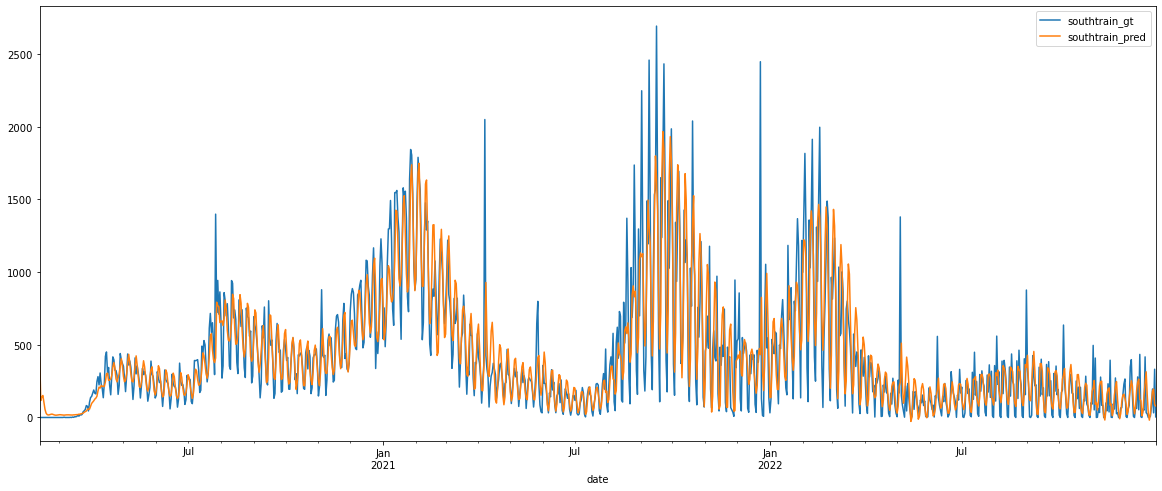

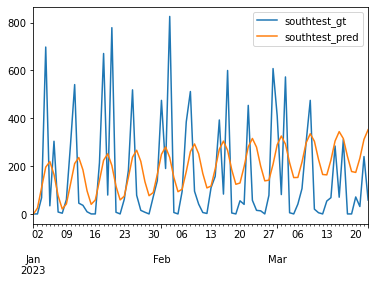

Training Set Metrics:
MAE: 140.31038896437462
MASE: 0.0003276523202590472

Testing Set Metrics:
MAE: 160.39669284827394
MASE: 0.01029069056930134


In [129]:
smodel = ARIMA(southtrain['daily_deaths'], order=(4, 0, 4))
smodel=smodel.fit()

southtrain_pred=smodel.fittedvalues
pd.concat([southtrain, southtrain_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['southtrain_gt', 'southtrain_pred'])
plt.show()

southtest_pred=smodel.predict(start=len(southtrain), end=len(southtrain)+len(southtest)-1, dynamic=True)
pd.concat([southtest, southtest_pred], axis=1).plot()
plt.legend(['southtest_gt', 'southtest_pred'])
plt.show()

# Calculate MAE for the training set
mae_train = mean_absolute_error(southtrain, southtrain_pred)
mase_train = MASE(southtrain, southtrain_pred)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)


# Calculate MAE for the testing set
mae_test = mean_absolute_error(southtest, southtest_pred)
mase_test = MASE(southtest, southtest_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

In [130]:
smodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           daily_deaths   No. Observations:                 1054
Model:                 ARIMA(4, 0, 4)   Log Likelihood               -7211.078
Date:                Thu, 15 Feb 2024   AIC                          14442.156
Time:                        17:13:22   BIC                          14491.759
Sample:                    02-12-2020   HQIC                         14460.960
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        415.9533    305.421      1.362      0.173    -182.661    1014.567
ar.L1          1.9975      4.992      0.400      0.689      -7.787      11.782
ar.L2         -1.6878     11.188     -0.151      0.880     -23.615      20.240
ar.L3          0.4411     11.155      0.040      0.968     -21.422      22.304
ar.L4          0.2412      4.926      0.049      0.961      -9.413       9.895
ma.L1         -1.7424      4.987     -0.349      0.727     -11.517       8.032
ma.L2          1.3227      9.918      0.133      0.894     -18.116      20.762
ma.L3         -0.2155      9.060     -0.024      0.981     -17.973      17.542
ma.L4         -0.1691      3.338     -0.051      0.960      -6.711       6.373
sigma2      6.328e+04   1779.560     35.557      0.000    5.98e+04    6.68e+04
===================================================================================
Ljung-Box (L1) (Q):                   8.24   Jarque-Bera (JB):              7296.10
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.96   Skew:                             2.02
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

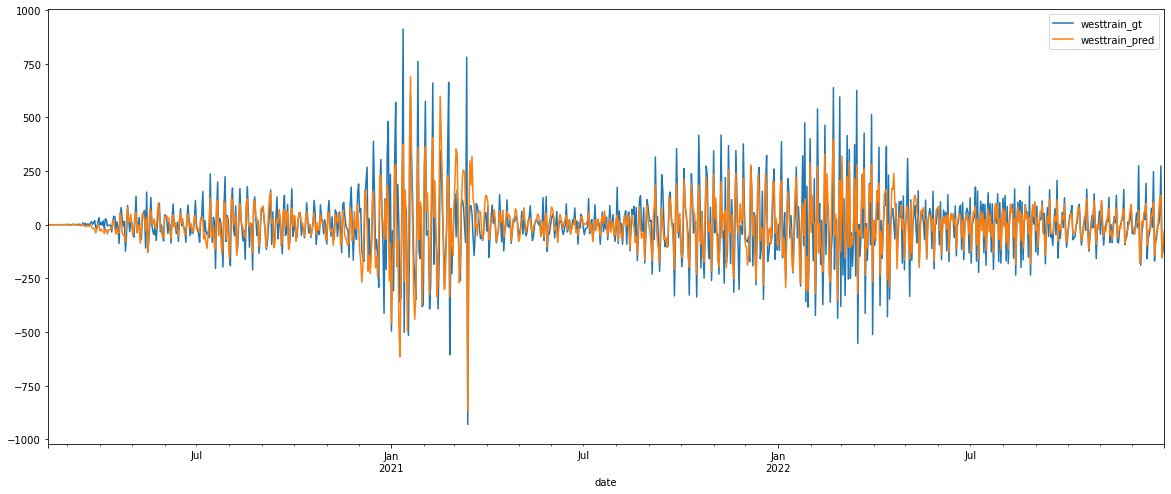

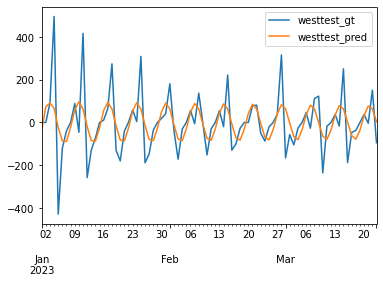

Training Set Metrics:
MAE: 64.73644619804111
MASE: 0.0004432472719242188

Testing Set Metrics:
MAE: 81.22106638626431
MASE: 0.008876237580782698


In [131]:
wmodel = ARIMA(westtrain['daily_deaths'], order=(4, 0, 4))
wmodel=wmodel.fit()

westtrain_pred=wmodel.fittedvalues
pd.concat([westtrain, westtrain_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['westtrain_gt', 'westtrain_pred'])
plt.show()

westtest_pred=wmodel.predict(start=len(westtrain), end=len(westtrain)+len(westtest)-1, dynamic=True)
pd.concat([westtest, westtest_pred], axis=1).plot()
plt.legend(['westtest_gt', 'westtest_pred'])
plt.show()

# Calculate MAE for the training set
mae_train = mean_absolute_error(westtrain, westtrain_pred)
mase_train = MASE(westtrain, westtrain_pred)
print("Training Set Metrics:")
print("MAE:", mae_train)
print("MASE:", mase_train)


# Calculate MAE for the testing set
mae_test = mean_absolute_error(westtest, westtest_pred)
mase_test = MASE(westtest, westtest_pred)

print("\nTesting Set Metrics:")
print("MAE:", mae_test)
print("MASE:", mase_test)

In [132]:
wmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           daily_deaths   No. Observations:                 1054
Model:                 ARIMA(4, 0, 4)   Log Likelihood               -6392.070
Date:                Thu, 15 Feb 2024   AIC                          12804.141
Time:                        17:13:38   BIC                          12853.744
Sample:                    02-12-2020   HQIC                         12822.945
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0859      0.987      0.087      0.931      -1.848       2.020
ar.L1          0.2841      0.077      3.696      0.000       0.133       0.435
ar.L2         -0.0336      0.093     -0.361      0.718      -0.216       0.149
ar.L3         -0.6549      0.082     -8.016      0.000      -0.815      -0.495
ar.L4         -0.2424      0.045     -5.367      0.000      -0.331      -0.154
ma.L1         -1.1224      0.074    -15.249      0.000      -1.267      -0.978
ma.L2          0.1998      0.135      1.485      0.137      -0.064       0.464
ma.L3          0.7457      0.129      5.780      0.000       0.493       0.999
ma.L4         -0.5174      0.058     -8.913      0.000      -0.631      -0.404
sigma2      1.569e+04    544.595     28.809      0.000    1.46e+04    1.68e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.88   Jarque-Bera (JB):              3388.82
Prob(Q):                              0.35   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                             0.94
Prob(H) (two-sided):                  0.72   Kurtosis:                        11.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# combined forecasts

Combined MAE (Training Set): 520.3645249560442


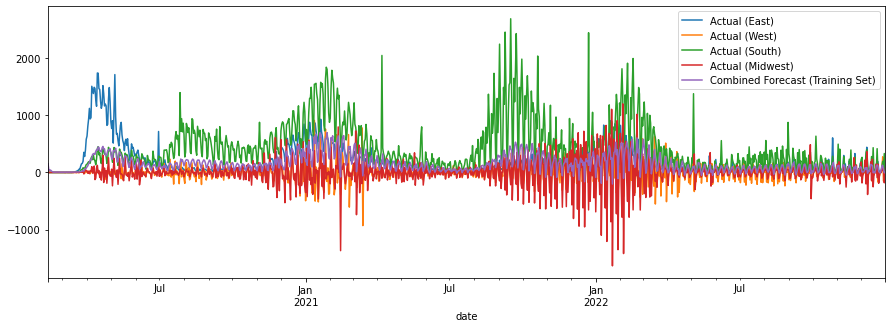

Combined MAE (Test Set): 278.60387319595236


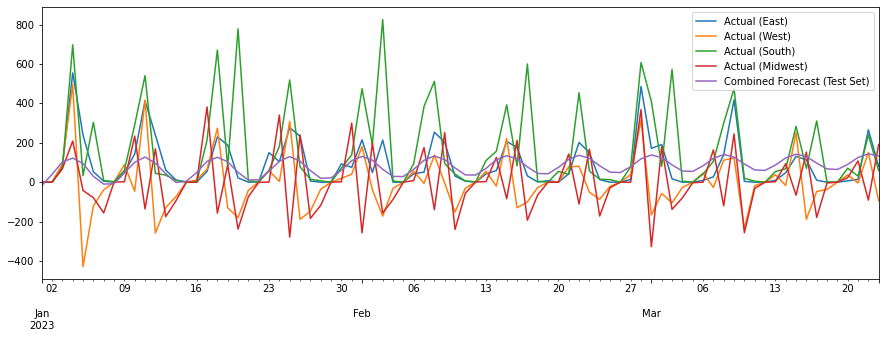

In [151]:
# Combine the forecasts for training set
combined_forecast_train = (easttrain_pred + westtrain_pred + southtrain_pred + midwesttrain_pred) / 4

# Evaluate and fine-tune as needed for training set
actual_values_combined_train = easttrain['daily_deaths'].values + westtrain['daily_deaths'].values + southtrain['daily_deaths'].values + midwesttrain['daily_deaths'].values

# Convert the combined forecast to a NumPy array for training set
predicted_values_combined_train = combined_forecast_train.values.flatten()

# Calculate MAE for training set
mae_combined_train = mean_absolute_error(actual_values_combined_train, predicted_values_combined_train)
print(f"Combined MAE (Training Set): {mae_combined_train}")

# Combine actual values for plotting for training set
actual_values_combined_train_df = pd.concat([easttrain['daily_deaths'], westtrain['daily_deaths'], southtrain['daily_deaths'], midwesttrain['daily_deaths']], axis=1)
actual_values_combined_train_df.columns = ['East', 'West', 'South', 'Midwest']

# Plot the actual values and combined forecast for training set
pd.concat([actual_values_combined_train_df, combined_forecast_train], axis=1).plot(figsize=(15, 5))
plt.legend(['Actual (East)', 'Actual (West)', 'Actual (South)', 'Actual (Midwest)', 'Combined Forecast (Training Set)'])
plt.show()

# Combine the forecasts for test set
combined_forecast_test = (easttest_pred + westtest_pred + southtest_pred + midwesttest_pred) / 4

# Evaluate and fine-tune as needed for test set
actual_values_combined_test = easttest['daily_deaths'].values + westtest['daily_deaths'].values + southtest['daily_deaths'].values + midwesttest['daily_deaths'].values

# Convert the combined forecast to a NumPy array for test set
predicted_values_combined_test = combined_forecast_test.values.flatten()

# Calculate MAE for test set
mae_combined_test = mean_absolute_error(actual_values_combined_test, predicted_values_combined_test)
print(f"Combined MAE (Test Set): {mae_combined_test}")

# Combine actual values for plotting for test set
actual_values_combined_test_df = pd.concat([easttest['daily_deaths'], westtest['daily_deaths'], southtest['daily_deaths'], midwesttest['daily_deaths']], axis=1)
actual_values_combined_test_df.columns = ['East', 'West', 'South', 'Midwest']

# Plot the actual values and combined forecast for test set
pd.concat([actual_values_combined_test_df, combined_forecast_test], axis=1).plot(figsize=(15, 5))
plt.legend(['Actual (East)', 'Actual (West)', 'Actual (South)', 'Actual (Midwest)', 'Combined Forecast (Test Set)'])
plt.show()


### COMBINED MASE

In [156]:
def combinedMASE(Actual, Predicted):
    n = len(Actual)

    # Calculate the Mean Absolute Error (MAE)
    mae = np.mean(np.abs(Actual - Predicted))

    # Calculate the denominator for 1D arrays
    denominator = 1 / (n - 1) * np.sum(np.abs(np.diff(Actual)))

    # Avoid division by zero or small denominators
    if denominator > 1e-6:
        mase = mae / denominator
    else:
        mase = np.inf

    return mase

# combine the forecasts - train
combined_forecast_train = (easttrain_pred + westtrain_pred + southtrain_pred + midwesttrain_pred) / 4

# Evaluate and fine-tune as needed - train
actual_values_combined_train = easttrain['daily_deaths'].values + westtrain['daily_deaths'].values + southtrain['daily_deaths'].values + midwesttrain['daily_deaths'].values

# Convert the combined forecast to a NumPy array - train
predicted_values_combined_mase_train = combined_forecast_train.values.flatten()

# Calculate MASE for combined forecast - train
mase_combined_train = combinedMASE(actual_values_combined_train, predicted_values_combined_mase_train)
print(f"Combined MASE train : {mase_combined_train}")

# Combine the forecasts - test
combined_forecast = (easttest_pred + westtest_pred + southtest_pred + midwesttest_pred) / 4

# Evaluate and fine-tune as needed - test
actual_values_combined = easttest['daily_deaths'].values + westtest['daily_deaths'].values + southtest['daily_deaths'].values + midwesttest['daily_deaths'].values

# Convert the combined forecast to a NumPy array - test
predicted_values_combined_mase = combined_forecast.values.flatten()

# Calculate MASE for combined forecast - test
mase_combined = combinedMASE(actual_values_combined, predicted_values_combined_mase)
print(f"Combined MASE test : {mase_combined}")


Combined MASE train : 1.1217576648235905
Combined MASE test : 0.743825232501801
